# Implementacion RNN a df_U_FR

1. [Carga del DataFrame](#carga-del-dataframe)
<br></br>
2. [Estudio de la Serie Temporal](#estudio-de-la-serie-temporal)
<br></br>
3. [RNN](#rnn)
<br></br>
3.1 [Escalado de Datos](#escalado-de-datos)
<br></br>
3.2 [Creación del Modelo](#creacion-del-modelo)
<br></br>
4. [Métricas](#metricas)
<br></br>
4.1 [RMSE](#rmse)
<br></br>
4.2 [MAPE](#mape)
5. [Mejora de la Predicción](#mejora-de-la-prediccion)
<br></br>
5.1 [Eliminación de Valores Negativos](#eliminacion-de-valores-negativos)
<br></br>
5.2 [Días de la Semana](#dias-de-la-semana)
<br></br>
6. [Conclusiones](#conclusiones)

In [1]:
%load_ext watermark
%watermark

2019-06-15T23:33:20+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


## 1. <a id='carga-del-dataframe'>Carga del DataFrame</a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (14,10)
warnings.filterwarnings('ignore')

In [3]:
df_U_FR_complete = pd.read_pickle('../Data/03a.-Implementacion-Prophet-a-df_U_FR_complete.pkl')

df_U_FR_complete.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [4]:
df_U_FR_complete.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


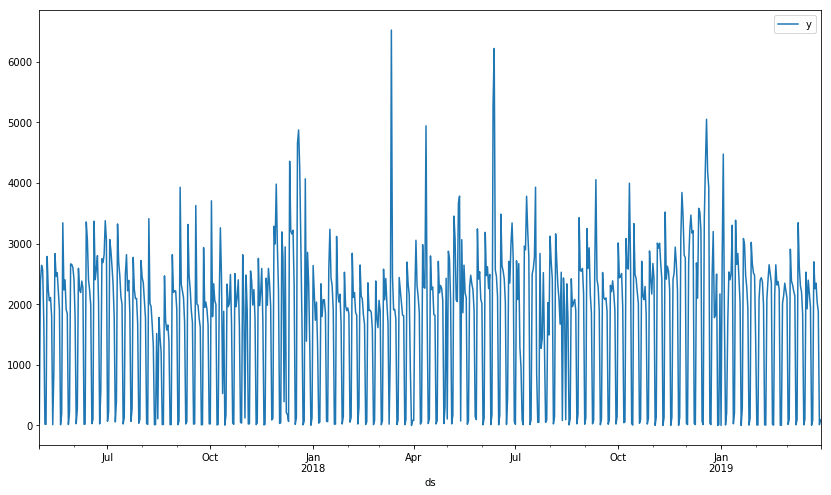

In [5]:
df_U_FR_complete.plot.line(x = 'ds',y = 'y',figsize = (14,8));

## 2. <a id='estudio-de-la-serie-temporal'>Estudio de la Serie Temporal</a>

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
df_U_FR_complete_statsmodel = df_U_FR_complete

df_U_FR_complete_statsmodel.set_index('ds',inplace = True)

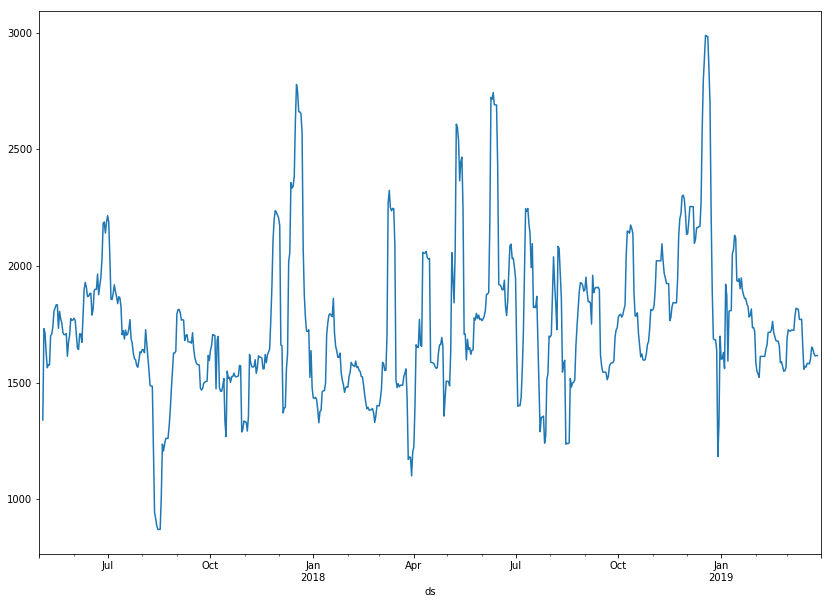

In [8]:
seasonal_decompose(df_U_FR_complete['y']).trend.plot(figsize = (14,10));

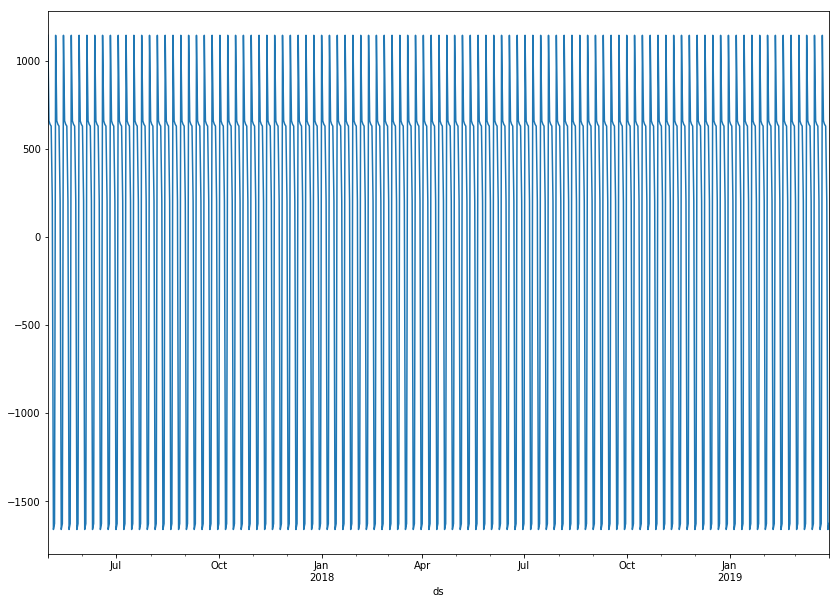

In [9]:
seasonal_decompose(df_U_FR_complete['y']).seasonal.plot(figsize = (14,10));

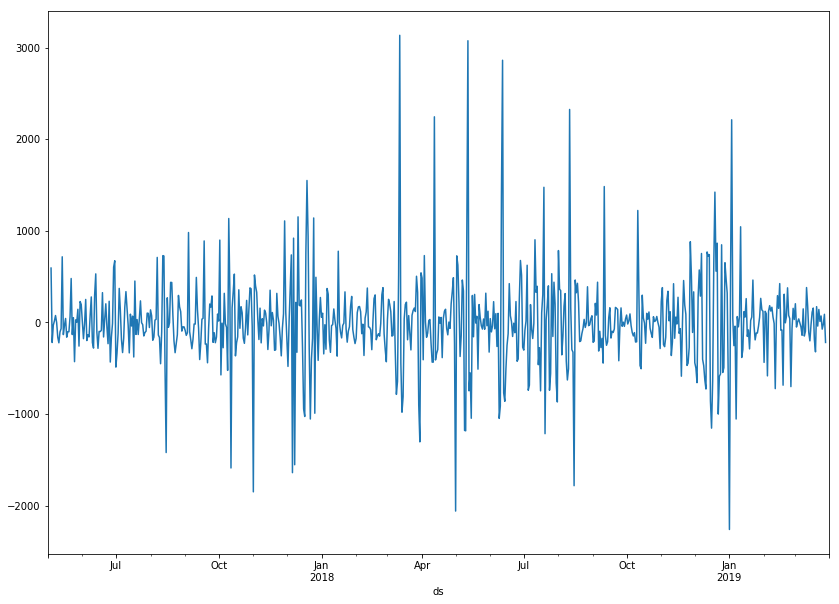

In [10]:
seasonal_decompose(df_U_FR_complete['y']).resid.plot(figsize = (14,10));

## 3. <a id='rnn'>RNN</a>

In [11]:
len(df_U_FR_complete)

700

In [12]:
df_train = df_U_FR_complete.iloc[:641]

df_test = df_U_FR_complete.iloc[641:]

### 3.1 <a id='escalado-de-datos'>Escalado de Datos</a>

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(df_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

### 3.2 <a id='creacion-del-modelo'>Creación del Modelo</a>

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [18]:
n_input = 7
n_features = 1

In [19]:
generator = TimeseriesGenerator(df_train_scaled,df_train_scaled,length = n_input,batch_size = 1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
f = Sequential()

In [22]:
f.add(LSTM(150, activation = 'relu',input_shape = (n_input,n_features)))
f.add(Dense(1))
f.compile(optimizer = 'adam',loss = 'mse')

In [23]:
f.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [24]:
f.fit_generator(generator,epochs = 30)

Epoch 1/30
634/634 [==============================] - 23s 36ms/step - loss: 0.0290
Epoch 2/30
634/634 [==============================] - 21s 33ms/step - loss: 0.0155
Epoch 3/30
634/634 [==============================] - 23s 36ms/step - loss: 0.0130
Epoch 4/30
634/634 [==============================] - 24s 38ms/step - loss: 0.0130
Epoch 5/30
634/634 [==============================] - 25s 40ms/step - loss: 0.0123
Epoch 6/30
634/634 [==============================] - 22s 35ms/step - loss: 0.0117
Epoch 7/30
634/634 [==============================] - 24s 37ms/step - loss: 0.0120
Epoch 8/30
634/634 [==============================] - 22s 34ms/step - loss: 0.0116
Epoch 9/30
634/634 [==============================] - 23s 36ms/step - loss: 0.0116
Epoch 10/30
634/634 [==============================] - 22s 35ms/step - loss: 0.0114
Epoch 11/30
634/634 [==============================] - 23s 36ms/step - loss: 0.0109
Epoch 12/30
634/634 [==============================] - 23s 37ms/step - loss: 0.0109
E

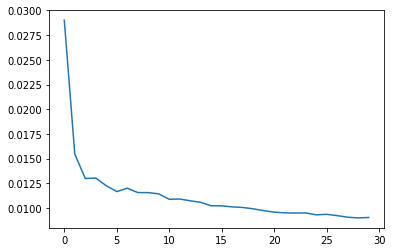

In [25]:
plt.plot(range(len(f.history.history['loss'])),f.history.history['loss']);

## 4. <a id='metricas'>Métricas</a>

In [26]:
test_predictions = []
first_eval_batch = df_train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(df_test)):
    current_pred = f.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

true_predictions

array([[ 2.21430486e+03],
       [ 1.97841009e+02],
       [ 1.39227366e+02],
       [ 3.63180520e+03],
       [ 3.15712223e+03],
       [ 3.04814247e+03],
       [ 2.78176853e+03],
       [ 2.38377440e+03],
       [ 2.72981393e+02],
       [ 1.01045412e+02],
       [ 3.75011614e+03],
       [ 3.22237685e+03],
       [ 3.11914916e+03],
       [ 2.83345598e+03],
       [ 2.42759509e+03],
       [ 3.49300581e+02],
       [ 5.07478581e+01],
       [ 3.77125174e+03],
       [ 3.22580059e+03],
       [ 3.12272711e+03],
       [ 2.83687545e+03],
       [ 2.43152109e+03],
       [ 4.23281800e+02],
       [ 1.48521445e+00],
       [ 3.78021702e+03],
       [ 3.22211076e+03],
       [ 3.12065010e+03],
       [ 2.83365059e+03],
       [ 2.42896513e+03],
       [ 4.95571130e+02],
       [-4.54133622e+01],
       [ 3.78459866e+03],
       [ 3.21678054e+03],
       [ 3.11735222e+03],
       [ 2.82920252e+03],
       [ 2.42518286e+03],
       [ 5.70683958e+02],
       [-9.03887067e+01],
       [ 3.7

In [28]:
df_test['Predictions'] = true_predictions

df_test.head()

,y,Predictions
ds,,
2019-02-01,1355,2214.304862
2019-02-02,11,197.841009
2019-02-03,6,139.227366
2019-02-04,2086,3631.805198
2019-02-05,2396,3157.122227


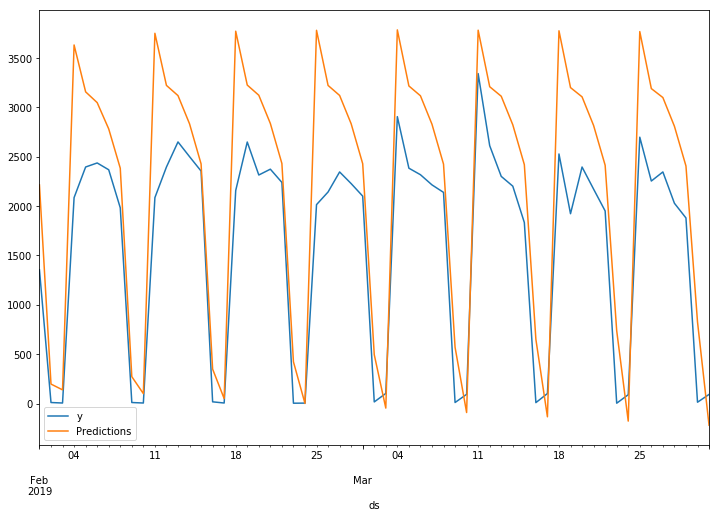

In [29]:
df_test.plot(figsize=(12,8));

In [30]:
df_test.tail()

,y,Predictions
ds,,
2019-03-27,2346,3099.547913
2019-03-28,2029,2808.619680
2019-03-29,1880,2406.397732
2019-03-30,14,827.520887
2019-03-31,93,-219.032687


### 4.1 <a id='rmse'>RMSE</a>

In [31]:
from statsmodels.tools.eval_measures import rmse

In [32]:
rmse(df_test['Predictions'],df_test['y'])

742.6791832686703

### 4.2 <a id='mape'>MAPE</a>

In [33]:
def mape(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_test['Predictions'],df_test['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 1052.9%


## 5. <a id='mejora-de-la-prediccion'>Mejora de la Predicción<a/>

### 5.1 <a id='eliminacion-de-valores-negativos'>Eliminación de Valores Negativos<a/>

In [35]:
df_test[df_test['Predictions'] < 0]

,y,Predictions
ds,,
2019-03-03,103,-45.413362
2019-03-10,94,-90.388707
2019-03-17,102,-133.542057
2019-03-24,90,-177.176203
2019-03-31,93,-219.032687


In [36]:
df_test.loc[df_test['Predictions'] < 0,'Predictions'] = 0

In [37]:
len(df_test[df_test['Predictions'] < 0])

0

In [38]:
rmse(df_test['Predictions'],df_test['y'])

740.0081823079859

In [39]:
df_test['y'].mean()

1596.8983050847457

In [40]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_test['Predictions'],df_test['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 1040.98%


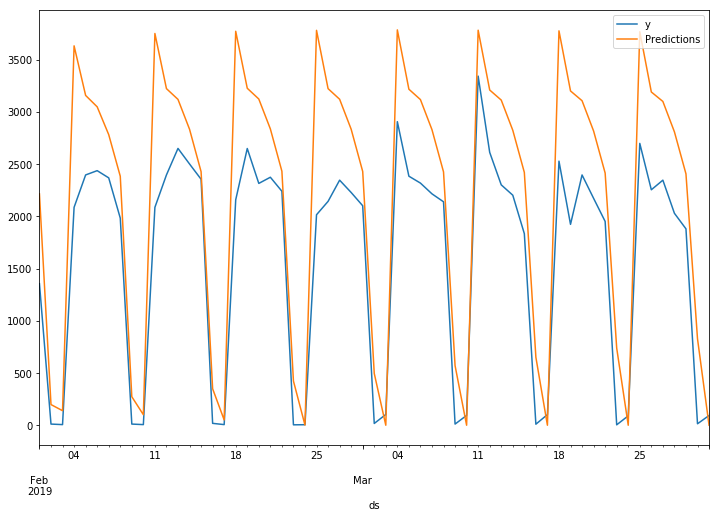

In [41]:
df_test.plot(figsize=(12,8));

### 5.2 <a id='dias-de-la-semana'>Días de la Semana<a/>

In [42]:
import datetime

In [43]:
df_test_dayofweek = df_test

In [44]:
df_test_dayofweek['ds'] = df_test_dayofweek.index

df_test_dayofweek.head()

,y,Predictions,ds
ds,,,
2019-02-01,1355,2214.304862,2019-02-01
2019-02-02,11,197.841009,2019-02-02
2019-02-03,6,139.227366,2019-02-03
2019-02-04,2086,3631.805198,2019-02-04
2019-02-05,2396,3157.122227,2019-02-05


In [45]:
df_test_dayofweek['dayofweek'] = df_test_dayofweek['ds'].dt.dayofweek

df_test_dayofweek.head()

,y,Predictions,ds,dayofweek
ds,,,,
2019-02-01,1355,2214.304862,2019-02-01,4
2019-02-02,11,197.841009,2019-02-02,5
2019-02-03,6,139.227366,2019-02-03,6
2019-02-04,2086,3631.805198,2019-02-04,0
2019-02-05,2396,3157.122227,2019-02-05,1


In [46]:
df_test_dayofweek = df_test_dayofweek.reset_index(drop = True)

df_test_dayofweek.head()

,y,Predictions,ds,dayofweek
0,1355,2214.304862,2019-02-01,4
1,11,197.841009,2019-02-02,5
2,6,139.227366,2019-02-03,6
3,2086,3631.805198,2019-02-04,0
4,2396,3157.122227,2019-02-05,1


In [47]:
df_test_dayofweek = df_test_dayofweek[df_test_dayofweek['dayofweek'] < 5]

df_test_dayofweek.head()

,y,Predictions,ds,dayofweek
0,1355,2214.304862,2019-02-01,4
3,2086,3631.805198,2019-02-04,0
4,2396,3157.122227,2019-02-05,1
5,2437,3048.142470,2019-02-06,2
6,2368,2781.768526,2019-02-07,3


In [48]:
rmse(df_test_dayofweek['Predictions'],df_test_dayofweek['y'])

850.9693473129466

In [49]:
df_test_dayofweek['y'].mean()

2283.2195121951218

In [50]:
def mape(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
print('El Error Porcentual Absoluto Medio (MAPE) es: {}%'.format(
    round(mape(df_test_dayofweek['Predictions'],df_test_dayofweek['y']),2)))

El Error Porcentual Absoluto Medio (MAPE) es: 34.25%


## 6. <a id='conclusiones'>Conclusiones</a>

* Se realiza un estudio de la serie temporal, y se comprueba visualmente que es difícil de trabajar con métodos clásicos de predicción como ARIMA o, incluso, con Prophet. Por tanto, quizás sea adecuado utilizar redes neuronales en este caso.
* Se crea una red neuronal con 1 capa de 150 neuronas. Y, para entrenarla se tiene en cuenta que la estacionalidad de la serie es semanal, lo que ya se dedujo utilizando Prophet.
* Se consigue una predicción con un MAPE del 1052.9%, que ya es considerablemente un peor punto de partida que el que se obtenía con Prophet (MAPE = 389.18%).
* Ya no se mejora más el modelo, pero sí la predicción teniendo en cuenta el conocimiento del negocio.
    * Se eliminan los valores negativos (pues los envíos no pueden ser negativos)
    * Se dejan de tener en cuenta los días de fin de semana (sábados y domingos) porque, al ser cantidades cercanas al 0, distorsionan en exceso el MAPE de la predicción, que es la métrica que utilizamos para valorar la predicción.
* Así, **el MAPE final es del 34.25% frente al 28.26% obtenido con Prophet**.